# Decadal Hohmann
2020/01/21
ver .2

In [1]:
import sys
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import spiceypy as spice
from scipy import optimize

sys.path.append(r'C:\Users\yurio\Documents\GitHub\orbital_pythontools')
import lambert as lb

rad2deg = 180/np.pi
au2km = 1.49597870691*10**8
mu = 132712440018

In [2]:
# rotational matrices
def rotMat(axis,theta):
    """Function computes rotational matrix going from one to another
    Args:
        axis (int): 1, 2, or 3 (axis about which to rotate)
    Returns:
    """
    if axis == 1:
        rotmat = np.array([[1, 0, 0],
                           [0, np.cos(theta), np.sin(theta)],
                           [0, -np.sin(theta), np.cos(theta)]])
    elif axis == 2:
        rotmat = np.array([[np.cos(theta), 0, -np.sin(theta)],
                           [0, 1, 0],
                           [np.sin(theta), 0, np.cos(theta)]])
    elif axis == 3:
        rotmat = np.array([[np.cos(theta), np.sin(theta), 0],
                           [-np.sin(theta), np.cos(theta), 0],
                           [0, 0, 1]])
    else:
        rotmat = NaN
        
    return rotmat


In [3]:
# import spice kernel of leap seconds and trajectory
spice.furnsh(r'C:\Users\yurio\Documents\spice\naif0012.tls')
spice.furnsh(r'C:\Users\yurio\Documents\spice\de430.bsp')
# https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/aa_summaries.txt

In [4]:
# time range
step = 4000
# we are going to get positions between these two dates
tstart = 'Jan 1,  2020'
tend   = 'Dec 31, 2040'

# get et values one and two, we could vectorize str2et
etOne = spice.str2et(tstart)
etTwo = spice.str2et(tend)
etMean = np.round((etOne+etTwo)/2)
print("ET One: {}, ET Two: {}".format(etOne, etTwo))
epochs = [x*(etTwo-etOne)/step + etOne for x in range(step)]

ET One: 631108869.1839073, ET Two: 1293796869.1838942


In [5]:
# function to convert mean anomaly to true anomaly
def meananom2trueanom(m0,ecc):
    """function converts mean anomaly to true anomaly
    Args:
        m0 (float): mean anomaly in radians
        e (float): eccentricity
    Returns:
        (float): true anomaly in radians
    Requirements:
        from scipy import optimize
    """
    # elliptical case
    if ecc>0 and ecc<1:
        def zeroEfunc(E,m0,ecc):
            fval = E - ecc*np.sin(E) - m0
            return fval
        def zeroEprime(E,ecc):
            fpval = 1 - ecc*np.cos(E)
            return fpval
        # initial guess of eccentric anomaly
        E0 = m0
        # Newton-raphson method to find E with initial guess E)
        E1 = optimize.newton(zeroEfunc, args=(m0,ecc), x0=E0)#, fprime=zeroEprime)
        theta = 2*np.arctan(np.sqrt((1+ecc)/(1-ecc))*np.tan(E1/2))
        
    else:
        theta = NaN
    # convert to positive theta in case >pi
    if theta < 0:
        theta = 2*np.pi + theta
    return theta
    
# function to convert state-vector to elements
def sv2el_spice(state,epoch,mu):
    """function converts state-vector to conical elements using spice.oscelt
    Args:
        state (lst): 6-elements state vector
        epoch (float): epoch in ephemeris seconds past J2000
        mu (float): gravitational parameter
    Returns:
        (dict): dictionary of orbital elements
    """
    rp,ecc,inc,lnode,argp,m0,t0,mu_out = spice.oscelt(state,epoch,mu)
    
    # compute semi-major axis
    if ecc < 1:
        a = rp/(1-ecc)
    elif ecc > 1:
        a = rp/(ecc-1)
    else:
        a = NaN
    
    # orbital period [s]
    P = 2 * np.pi * np.sqrt(a**3/mu)
    # orbital speed [rad/s]
    n = 2*np.pi / P
    
    # true anomaly
    theta = meananom2trueanom(m0,ecc)
    
    # orbital radius
    if ecc < 1:
        r = a*(1-ecc**2)/(1+ecc*np.cos(theta))
    elif ecc > 1:
        r = a*(ecc**2-1)/(1+ecc*np.cos(theta))
        
    # perifocal frame x, y coordinates
    rxPF = r*np.cos(theta)
    ryPF = r*np.sin(theta)
    rPF = np.array([rxPF,ryPF,0])
    
    elts = {'rp':rp, 'ecc':ecc, 'inc':inc, 'lnode':lnode, 'argp':argp,
            'm0':m0,'t0':t0,'a':a, 'P':P, 'n':n, 'theta':theta, 'r':r, 'rPF':rPF}
    return elts

In [6]:
# extract range over epoch range
e_rx = []
e_ry = []
e_rz = []
m_rx = []
m_ry = []
m_rz = []
for i in range(len(epochs)):
    # extract state
    earth_rv = spice.spkssb(3,epochs[i],'J2000')
    mars_rv  = spice.spkssb(4,epochs[i],'J2000')
    # save positions for earth
    e_rx.append( earth_rv[0]/au2km )
    e_ry.append( earth_rv[1]/au2km )
    e_rz.append( earth_rv[2]/au2km )
    # save positions for mars
    m_rx.append( mars_rv[0]/au2km )
    m_ry.append( mars_rv[1]/au2km )
    m_rz.append( mars_rv[2]/au2km )

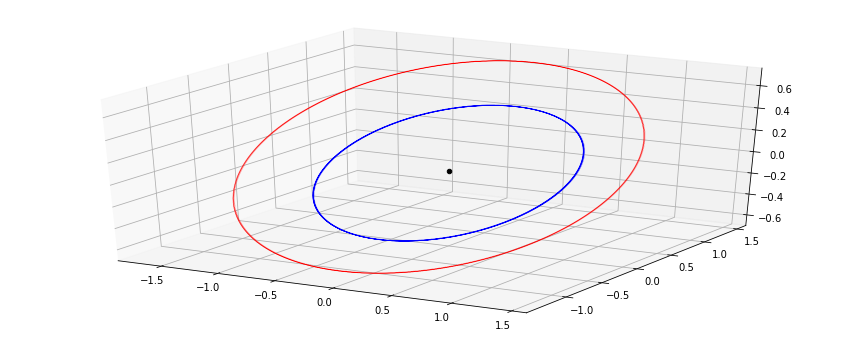

In [7]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(111, aspect='auto',projection='3d')
ax.scatter(0,0,c='k')
ax.plot(e_rx, e_ry, e_rz, c='b', linewidth='0.1')
ax.plot(m_rx, m_ry, m_rz, c='r', linewidth='0.1')
ax.grid()
plt.show()

In [8]:
# reference HTO transfer
dep_state = spice.spkssb(3,etMean,'J2000')   # (3): Earth barycenter w.r.t. SSB
arr_state = spice.spkssb(4,etMean,'J2000')   # (4): Mars barycenter w.r.t. SSB
dep_elts = sv2el_spice(dep_state,etMean,mu)
arr_elts = sv2el_spice(arr_state,etMean,mu)

a_HTO = (dep_elts.get('a') + arr_elts.get('a'))/2
tof_HTO = np.pi * np.sqrt(a_HTO**3/mu)
print(f'Hohmann semi-major axis a = {a_HTO} km')
print(f'Time of flight via HTO: {tof_HTO/(60*60*24)} days')
phase_req = np.pi - arr_elts.get('n') * tof_HTO
print(f'Phase required: {phase_req*rad2deg} deg')


Hohmann semi-major axis a = 188808764.81845635 km
Time of flight via HTO: 258.94858359039347 days
Phase required: 44.668449275182525 deg


In [9]:
# initialize list for epoch to HTO
tmp_lst = []

for i in range(len(epochs)):
    # compute state-vector
    sv0 = spice.spkssb(3,epochs[i],'J2000')  # (3): Earth barycenter w.r.t. SSB
    sv1 = spice.spkssb(4,epochs[i],'J2000')  # (4): Mars barycenter w.r.t. SSB
    # extract positions
    r0  = np.array([sv0[0],sv0[1],sv0[2]])
    r1  = np.array([sv1[0],sv1[1],sv1[2]])
    # angle between dep. and arr. vectors
    phi0 = np.arccos( np.dot(r0,r1)/(norm(r0)*norm(r1)) )
    # orientation between dep. and arr. vectors
    planet_orientation = np.cross(r0,r1) / norm(np.cross(r0,r1))
    # check phase angle
    phi_err = np.abs(phase_req - phi0) * rad2deg  # error in phase angle [deg]
    if phi_err < 1 and planet_orientation[2] > 0:
        print(f'Hohmann window at {spice.et2utc(epochs[i],"C",3)}')
        #print(epochs[i])
        tmp_lst.append(epochs[i])

Hohmann window at 2020 JUN 02 09:35:59.999
Hohmann window at 2020 JUN 04 07:37:11.999
Hohmann window at 2020 JUN 06 05:38:23.999
Hohmann window at 2022 AUG 24 10:04:48.001
Hohmann window at 2022 AUG 26 08:06:00.001
Hohmann window at 2022 AUG 28 06:07:12.001
Hohmann window at 2024 OCT 22 10:19:12.001
Hohmann window at 2024 OCT 24 08:20:24.001
Hohmann window at 2026 DEC 02 06:21:36.001
Hohmann window at 2026 DEC 04 04:22:48.001
Hohmann window at 2029 JAN 05 08:20:24.000
Hohmann window at 2029 JAN 07 06:21:36.000
Hohmann window at 2031 FEB 07 12:17:59.999
Hohmann window at 2031 FEB 09 10:19:11.999
Hohmann window at 2033 MAR 15 12:17:59.998
Hohmann window at 2033 MAR 17 10:19:11.998
Hohmann window at 2035 MAY 06 20:27:35.998
Hohmann window at 2035 MAY 08 18:28:47.999
Hohmann window at 2037 JUL 22 02:52:48.000
Hohmann window at 2037 JUL 24 00:54:00.000
Hohmann window at 2037 JUL 25 22:55:12.000
Hohmann window at 2037 JUL 27 20:56:24.001
Hohmann window at 2039 OCT 03 13:15:36.002
Hohmann win

In [10]:
# condense epochs to singular windows of epochs
epoch_HTO = []
dt = epochs[1] - epochs[0]
tmp_sublst = []
tmp_ct = 1

for i in range(len(tmp_lst)-1):
    if tmp_lst[i+1] - tmp_lst[i] < 1.2*dt:
        tmp_sublst.append(tmp_lst[i])
        tmp_ct += 1
        
    elif tmp_lst[i+1] - tmp_lst[i] >= 1.2*dt:
        tmp_sublst.append(tmp_lst[i])
        epoch_HTO.append(sum(tmp_sublst)/tmp_ct)
        
        del tmp_sublst[:]
        tmp_ct = 1
    
    if i == len(tmp_lst)-2:
        tmp_sublst.append(tmp_lst[i+1])
        epoch_HTO.append(sum(tmp_sublst)/tmp_ct)
        
for j in range(len(epoch_HTO)):
    print(f'Hohmann launch window at {spice.et2utc(epoch_HTO[j],"C",3)}')


Hohmann launch window at 2020 JUN 04 07:37:11.999
Hohmann launch window at 2022 AUG 26 08:06:00.001
Hohmann launch window at 2024 OCT 23 09:19:48.001
Hohmann launch window at 2026 DEC 03 05:22:12.001
Hohmann launch window at 2029 JAN 06 07:21:00.000
Hohmann launch window at 2031 FEB 08 11:18:35.999
Hohmann launch window at 2033 MAR 16 11:18:35.998
Hohmann launch window at 2035 MAY 07 19:28:11.999
Hohmann launch window at 2037 JUL 24 23:54:36.000
Hohmann launch window at 2039 OCT 04 12:16:12.002


In [11]:
# initialize
deppos_rx = []
deppos_ry = []
deppos_rz = []
arrpos_rx = []
arrpos_ry = []
arrpos_rz = []
thetasize = 1000
x_HTO = np.zeros([len(epoch_HTO),thetasize])   # (num. of transfer, 1000)
y_HTO = np.zeros([len(epoch_HTO),thetasize])
z_HTO = np.zeros([len(epoch_HTO),thetasize])

for i in range(len(epoch_HTO)):
    # extract departure and arrival states
    dep_rv = spice.spkssb(3,epoch_HTO[i],'J2000')
    arr_rv = spice.spkssb(4,epoch_HTO[i]+tof_HTO,'J2000')
    # save positions for earth at departure epoch
    deppos_rx.append( dep_rv[0]/au2km )
    deppos_ry.append( dep_rv[1]/au2km )
    deppos_rz.append( dep_rv[2]/au2km )
    # save position for mars at arrival epoch
    arrpos_rx.append( arr_rv[0]/au2km )
    arrpos_ry.append( arr_rv[1]/au2km )
    arrpos_rz.append( arr_rv[2]/au2km )
    # solve Lambert problem with departure and arrival states
    dep_r00 = np.array([dep_rv[0], dep_rv[1], dep_rv[2]])
    arr_r00 = np.array([arr_rv[0], arr_rv[1], arr_rv[2]])
    dep_vHTO,arr_vHTO = lb.lambert(mu=mu, r1=dep_r00, r2=arr_r00, tof=tof_HTO, grade='pro')
    
    # create state-vector at departure at arrival
    dep_state = [*dep_r00, *dep_vHTO]
    arr_state = [*arr_r00, *arr_vHTO]
    # convert state-vector to elements
    dep_elts = sv2el_spice(dep_state, epoch_HTO[0], mu)
    arr_elts = sv2el_spice(arr_state, epoch_HTO[0]+tof_HTO, mu)
    
    # prepare rotational matrix from elt
    rom   = rotMat(3,-dep_elts.get('argp'))
    rinc  = rotMat(1,-dep_elts.get('inc'))
    rraan = rotMat(3,-dep_elts.get('lnode'))
    # construct rotation for particular transfer orbit
    tmp1 = np.dot(rraan,rinc)
    tmp2 = np.dot(tmp1,rom)
    
    # create coordinates of transfer
    theta_start = dep_elts.get('theta')
    theta_end   = arr_elts.get('theta')
    print(f'theta ranging from {theta_start} to {theta_end}')
    if theta_start < theta_end:
        theta_ar = np.linspace(theta_start, theta_end, thetasize)
    if theta_start > theta_end:
        theta_ar = np.linspace(theta_start, theta_end+2*np.pi, thetasize)
    
    for k in range(len(theta_ar)):
        rnorm = dep_elts.get('a')*(1-(dep_elts.get('ecc'))**2)/(1+dep_elts.get('ecc')*np.cos(theta_ar[k]))
        rPF = np.array([rnorm*np.cos(theta_ar[k]), rnorm*np.sin(theta_ar[k]), 0])
        # rotate from perifocal to 3D frame
        rGEC = np.dot(tmp2,rPF)
        # store coordinates
        x_HTO[i,k] = rGEC[0]/au2km
        y_HTO[i,k] = rGEC[1]/au2km
        z_HTO[i,k] = rGEC[2]/au2km
        
x_HTO.shape

theta ranging from 5.702775828951844 to 2.8606703409362106
theta ranging from 6.146229293362356 to 2.9213996614752946
theta ranging from 0.30186093353984783 to 3.1488351817002167
theta ranging from 0.5136672495011937 to 3.3531570069688157
theta ranging from 0.5421027394236512 to 3.5069919969877166
theta ranging from 0.28131729028616015 to 3.487403015026521
theta ranging from 6.0610849512443 to 3.213618937411744
theta ranging from 5.697472647506348 to 2.915288267146619
theta ranging from 5.8925049212058465 to 2.835878509809877
theta ranging from 0.15427901616593578 to 3.055396740311462


(10, 1000)

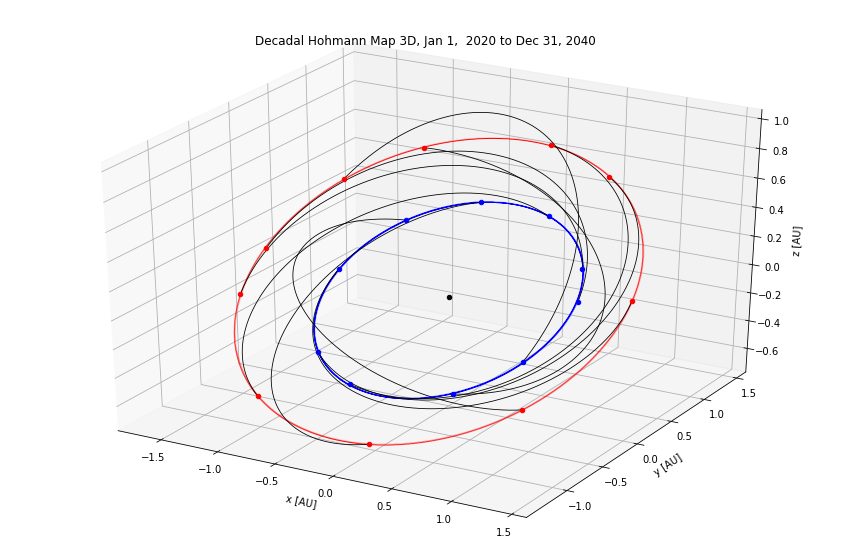

In [12]:
#%matplotlib
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, aspect='auto',projection='3d')
ax.scatter(0, 0, 0, c='k')
ax.plot(e_rx, e_ry, e_rz, c='b', linewidth='0.1')
ax.plot(m_rx, m_ry, m_rz, c='r', linewidth='0.1')

for i in range(len(epoch_HTO)):
    # plot dep. and arrival positions
    ax.scatter(deppos_rx[i], deppos_ry[i], deppos_rz[i], c='b', label=f'dep. {i+1}th transfer')
    ax.scatter(arrpos_rx[i], arrpos_ry[i], arrpos_rz[i], c='r')
    # plot trajectory
    ax.plot(x_HTO[i,:], y_HTO[i,:], z_HTO[i,:], c='k', linewidth='0.8')
    # put label
    lblful = spice.et2utc(epoch_HTO[i],"ISOC",0)
    label = lblful[:10]
    #label = "{:.2f}".format(epoch_HTO[i])
    #plt.annotate(label,                        # this is the text
    #             (deppos_rx[i], deppos_ry[i], deppos_rz[i]), # this is the point to label
    #             textcoords="offset points",   # how to position the text
    #             xytext=(0,10),                # distance from text to points (x,y)
    #             ha='center')                  # horizontal alignment can be left, right or center

plt.title(f'Decadal Hohmann Map 3D, {tstart} to {tend}')
ax.set_xlabel('x [AU]')
ax.set_ylabel('y [AU]')
ax.set_zlabel('z [AU]')
ax.grid()
plt.show()

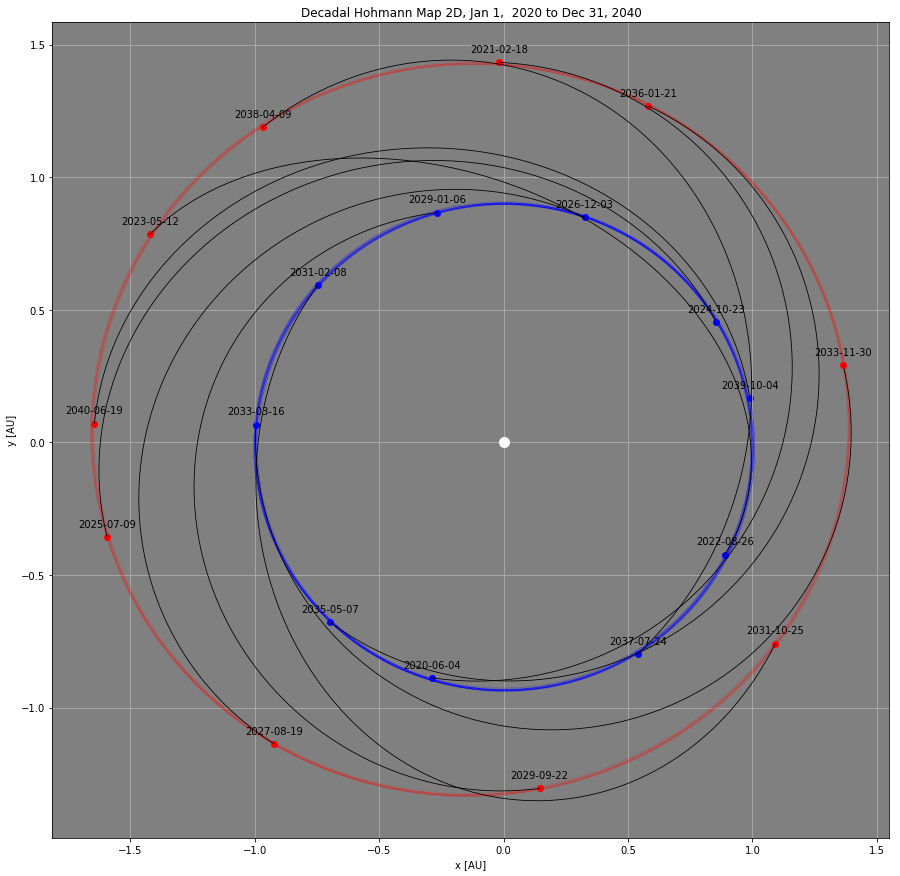

In [13]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, aspect='auto')
ax.set_facecolor("grey")
#ax.scatter(0, 0, c='y')
ax.plot(0,0,'wo',markersize=10)
ax.plot(e_rx, e_ry, c='b', linewidth='0.1')
ax.plot(m_rx, m_ry, c='r', linewidth='0.1')

for i in range(len(epoch_HTO)):
    # plot dep. and arrival positions
    ax.scatter(deppos_rx[i], deppos_ry[i], c='b')
    ax.scatter(arrpos_rx[i], arrpos_ry[i], c='r')
    
    # plot trajectory
    ax.plot(x_HTO[i,:], y_HTO[i,:], c='k', linewidth='0.8')
    
    # put label at departure
    lblfuldep = spice.et2utc(epoch_HTO[i],"ISOC",0)
    labeldep  = lblfuldep[:10]
    #label = "{:.2f}".format(epoch_HTO[i])
    plt.annotate(labeldep,                     # this is the text
                 (deppos_rx[i], deppos_ry[i]), # this is the point to label
                 textcoords="offset points",   # how to position the text
                 xytext=(0,10),                # distance from text to points (x,y)
                 ha='center')                  # horizontal alignment can be left, right or center
    # put label at arrival
    lblfularr = spice.et2utc(epoch_HTO[i]+tof_HTO,"ISOC",0)
    labelarr  = lblfularr[:10]
    #label = "{:.2f}".format(epoch_HTO[i])
    plt.annotate(labelarr,                     # this is the text
                 (arrpos_rx[i], arrpos_ry[i]), # this is the point to label
                 textcoords="offset points",   # how to position the text
                 xytext=(0,10),                # distance from text to points (x,y)
                 ha='center')                  # horizontal alignment can be left, right or center
    
plt.title(f'Decadal Hohmann Map 2D, {tstart} to {tend}')
ax.set_xlabel('x [AU]')
ax.set_ylabel('y [AU]')
#ax.legend()
ax.grid()
plt.show()